Problem: Sometimes the "slowest" / "rarest" transition in your simulation dataset (i.e. tIC1) corresponds to a "small" change that can be safely ignored for some purposes. For example, perhaps there's a slow sidechain rearrangement far away from the active site, which you might want to ignore when estimating affinities at the active set.

Sometimes the slowest processes are approximately irrelevant in some way:
- They are not likely to impact your estimates of the observables / equilibrium expectation values of interest.
- They are not likely to be "causal" -- if you manually set the "slow" DOF one way or another, the rest of the system doesn't behave differently.

Can we automatically recover from this problem?

Brainstorming ways to check:
- Let's say you've found a direction (let's call it tIC1) along which your dataset appears bimodal. I.e. you can pick a threshold value along this direction that your system very rarely crosses, and where a substantial portion of the data lie on either side of the threshold.
    - Hooray! You've found a "slow process."
    - However, you may have found a useless slow process, if this doesn't change anything
    - Restrict your attention to the datasets on either side of this divider.
    - If the kinetics within the subspace orthogonal to tIC1 on either side of the divider are ~ identical, then tIC1 probably isn't super helpful to look at...
- When transformed by tICA, this "kinetic irrelevance" might show up as a _translational symmetry_? For example, let's say there are two main conformations. If, within each, there's a very rare sidechain rearrangement that doesn't impact the behavior of the rest of the system, then to tICA it might look like there are _4_ distinct states, but really there are just two main states, with an ignorable internal barrier within each main state.

...

In any case, it would help in investigating this if the coordinates we use are _one-sparse_ and interpretable.

In this notebook, I explore an idea suggested by Guillermo Perez-Hernandez, which is to replace each tIC with the single feature most correlated with it (use closed-form expression for the feature-tIC correlations he contributed to PyEMMA): https://github.com/markovmodel/PyEMMA/blob/v2.2.5/pyemma/coordinates/transform/tica.py#L346

Another approach recently developed by Robert McGibbon is to find sparse solutions to tICA's generalized eigenvalue problem directly: https://arxiv.org/pdf/1602.08776.pdf . This should always produce better models, but here I specifically want all the components of my approximation to be exactly 1-sparse.

In [87]:
# test case: the example MetEnkephalin dataset
from msmbuilder.example_datasets import MetEnkephalin
print(MetEnkephalin().get().DESCR)
trajs = MetEnkephalin().get().trajectories
import pyemma
feat = pyemma.coordinates.featurizer(trajs[0].top)
feat.add_distances(range(trajs[0].n_atoms))
X = map(feat.transform, trajs)
tica = pyemma.coordinates.tica(X, lag=10, dim=50)
X_tica = tica.get_output()
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica, k=500, max_iter=10)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

The dataset consists of ten ~50 ns molecular dynamics (MD) simulation
trajectories of the 5 residue Met-enkaphalin peptide. The aggregate
sampling is 499.58 ns. Simulations were performed starting from the 1st
model in the 1PLX PDB file, solvated with 832 TIP3P water molecules using
OpenMM 6.0. The coordinates (protein only -- the water was stripped)
are saved every 5 picoseconds. Each of the ten trajectories is roughly
50 ns long and contains about 10,000 snapshots.

Forcefield: amber99sb-ildn; water: tip3p; nonbonded method: PME; cutoffs:
1nm; bonds to hydrogen were constrained; integrator: langevin dynamics;
temperature: 300K; friction coefficient: 1.0/ps; pressure control: Monte
Carlo barostat (interval of 25 steps); timestep 2 fs.

The dataset is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1026324

01-10-16 12:43:12 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[5] WARNING  The 1D arrays input for add_distances() have been sorted, and index dupli

In [89]:
import nglview
superposed = trajs[0].superpose(trajs[0])

view = nglview.show_mdtraj(superposed)
view.clear_representations()
view.add_hyperball()
view

In [90]:
500 * nanoseconds / (2 * femtoseconds)

249999999.99999997

In [91]:
import pyemma

In [92]:
# let's do diffusion distance instead?
from scipy.spatial.distance import squareform, pdist

def diffusion_cluster(msm, tau=10, n_states=6):
    affinity_matrix = 1 - 0.5 * squareform(pdist(np.linalg.matrix_power(msm.P,tau), p = 1))
    clust = SpectralClustering(n_states,affinity='precomputed')
    clust.fit(affinity_matrix)
    argsorted= np.argsort(clust.labels_)
    plt.imshow(np.log(msm.P)[argsorted][:,argsorted],
               interpolation='none',cmap='Blues')
    plt.figure()
    plt.imshow(affinity_matrix[argsorted][:,argsorted],
               interpolation='none',cmap='Blues')
    plt.colorbar()
    
    return affinity_matrix, clust.labels_

In [93]:
msm = pyemma.msm.estimate_markov_model(dtrajs, 10)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


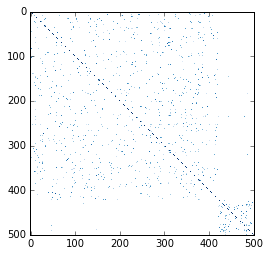

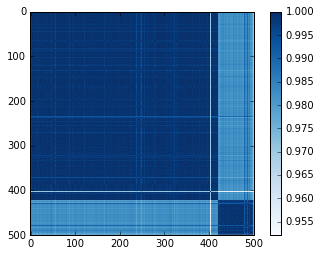

In [94]:
affinity_matrix, cg = diffusion_cluster(msm, tau = 1000, n_states=2)

In [95]:
trajs[0].xyz.shape

(9979, 75, 3)

In [96]:
from simtk.unit import *
(5 * picosecond) / (2 * femtosecond)

2500.0

In [97]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

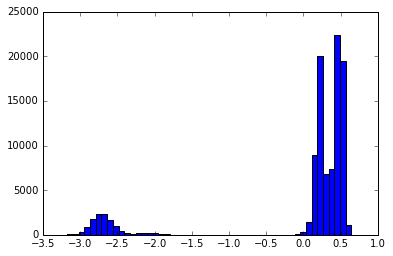

In [98]:
plt.hist(np.vstack(X_tica)[:,0],bins=50);

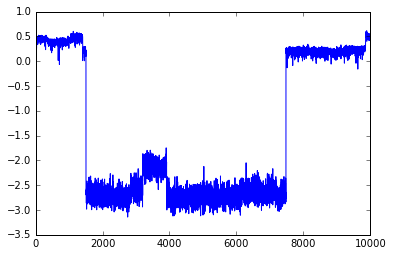

In [99]:
plt.plot(X_tica[0][:,0])

In [100]:
# what are some of the coordinates most correlated with tIC1

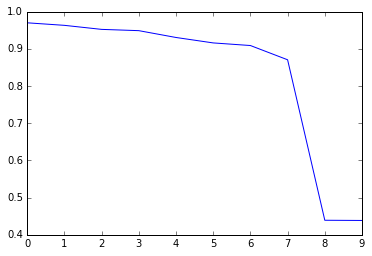

In [101]:
plt.plot(sorted(np.abs(tica.feature_TIC_correlation[:,0]))[::-1][:10])

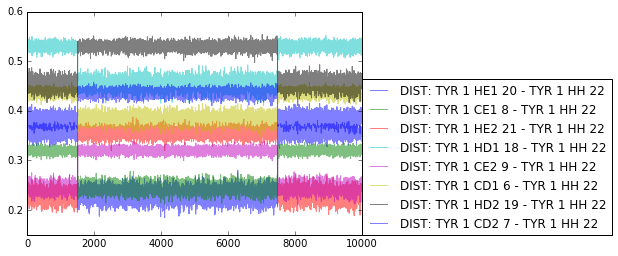

In [102]:
inds = np.argsort(np.abs(tica.feature_TIC_correlation[:,0]))[::-1]

for i in range(8):
    plt.plot(X[0][:,inds[i]],alpha=0.5, label=feat.describe()[inds[i]])
plt.legend(loc=(1,0))

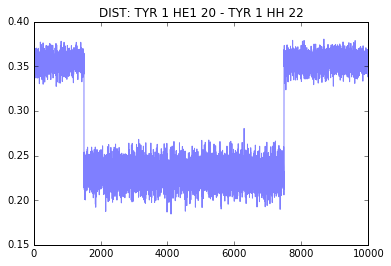

In [103]:
i = 0
plt.title(feat.describe()[inds[i]])
plt.plot(X[0][:,inds[i]],alpha=0.5)

In [106]:
transition_frame = np.argmax(X[0][:,inds[i]] < 0.30)
transition_frame

1506

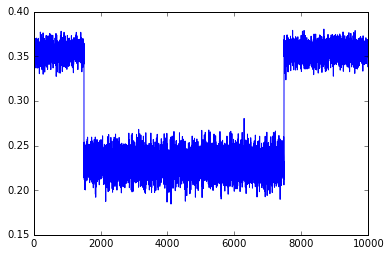

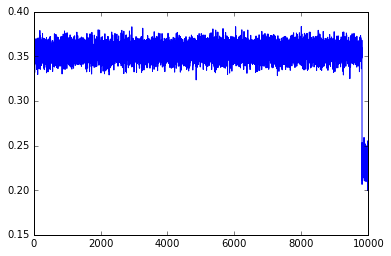

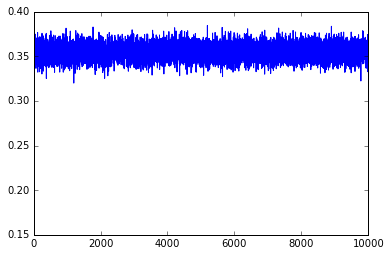

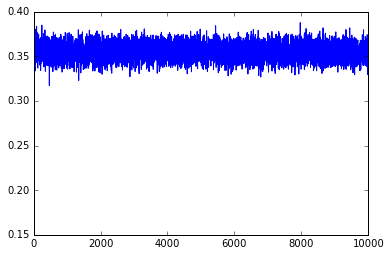

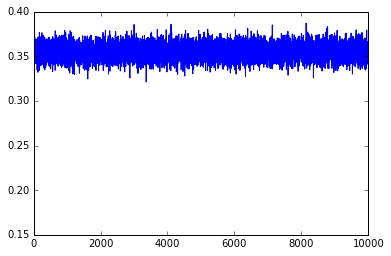

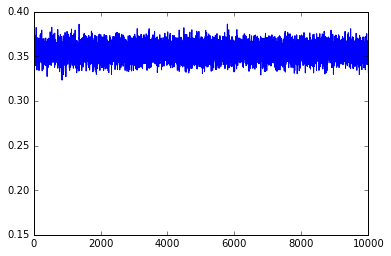

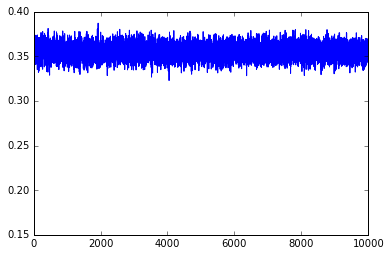

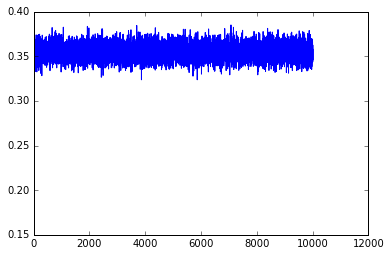

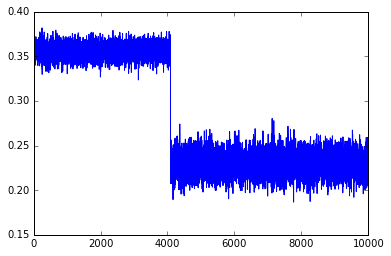

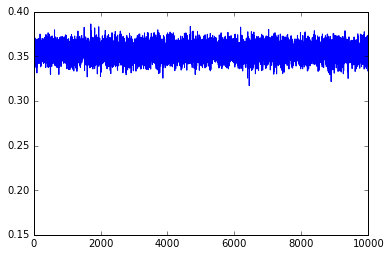

In [110]:
ind_x = inds[0]
for x in X:
    plt.figure()
    plt.plot(x[:,ind_x])
    plt.ylim(0.15,0.4)

In [111]:
n_buffer = 1
reactive_traj = trajs[0][transition_frame - n_buffer : transition_frame + n_buffer]
reactive_traj = reactive_traj.superpose(reactive_traj)

In [112]:
view = nglview.show_mdtraj(reactive_traj)
view.clear_representations()
view.add_hyperball()
view

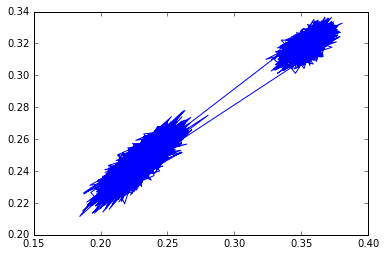

In [104]:
plt.plot(X[0][:,inds[0]], X[0][:,inds[1]])

In [11]:
from glob import glob
import mdtraj as md
fnames = glob('data/fah/10470/*.h5')
trajs = map(md.load, fnames)

In [12]:
trajs[0].top.n_residues

164

In [13]:
sum(map(len, trajs))

210555

In [14]:
len(trajs)

301

In [15]:
traj = trajs[0]

In [10]:
%%time

projections = [md.compute_contacts(traj, contacts=[[50,150]], scheme = 'closest')[0] for traj in trajs]

CPU times: user 132 ms, sys: 2.61 ms, total: 134 ms
Wall time: 134 ms


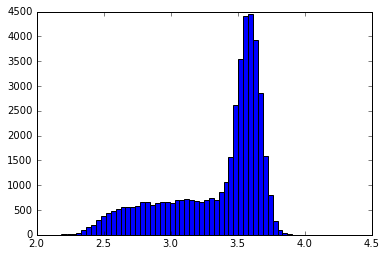

In [12]:
plt.hist(np.vstack(projections).flatten(),bins=50);

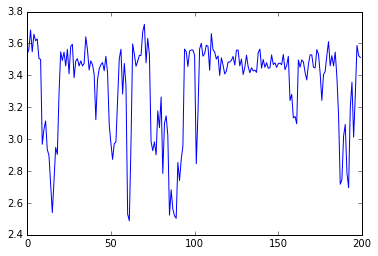

In [13]:
plt.plot(md.compute_contacts(traj, contacts=[[50,150]], scheme = 'closest')[0].flatten())

CPU times: user 121 ms, sys: 2.81 ms, total: 124 ms
Wall time: 122 ms


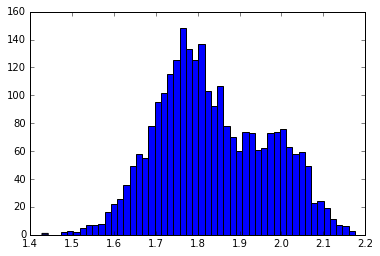

In [14]:
%%time
projections = [ md.compute_contacts(traj, contacts=[[60,160]], scheme = 'closest')[0] for traj in trajs[::10]]
plt.hist(np.vstack(projections).flatten(),bins=50);

In [16]:
# let's pick a random subset of contacts
np.random.seed(0)
all_pairs = []
for i in range(trajs[0].top.n_residues):
    for j in range(i):
        all_pairs.append((i,j))
np.random.shuffle(all_pairs)

In [17]:
pairs = all_pairs[:2000]

In [18]:
1.0 * len(pairs) / len(all_pairs)

0.14963339817447255

In [19]:
feat = pyemma.coordinates.featurizer(trajs[0].top)
feat.add_residue_mindist(pairs, scheme = 'closest')

In [23]:
#%%time
#def transform(traj):
#    feat = pyemma.coordinates.featurizer(trajs[0].top)
#    feat.add_residue_mindist(pairs, scheme = 'closest')
#    return feat.transform(traj)
#
#from multiprocessing import Pool
#pool = Pool(8)
#X = pool.map(transform, trajs)

In [20]:
from tqdm import tqdm

X = [feat.transform(traj) for traj in tqdm(trajs)]

100%|██████████| 301/301 [22:59<00:00,  5.68s/it]


In [21]:
lag_time = 10 * nanoseconds
recording_interval = 250 * picoseconds
lag_frames = int(lag_time / recording_interval)
lag_frames

40

In [22]:
tica = pyemma.coordinates.tica(X, lag = lag_frames, dim=50)
tica.ndim

50

In [23]:
X_tica = tica.get_output()

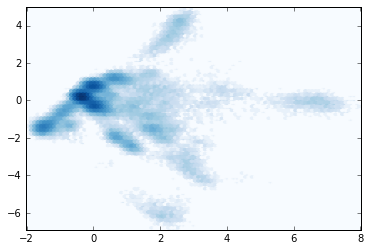

In [24]:
plt.hexbin(np.vstack(X_tica)[:,0], np.vstack(X_tica)[:,1], cmap='Blues', bins='log')

(0.72220636250799986, 0.57452440417037565)


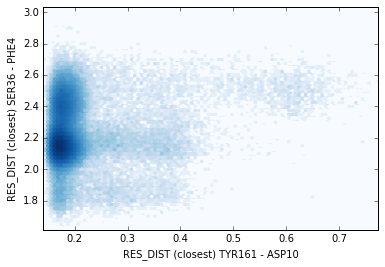

In [25]:
def sparsify(X, feat, tica):
    ''' given a tICA object, the top 2 tICs with their most correlated input feature'''
    
    ind_x, ind_y = np.argmax(np.abs(tica.feature_TIC_correlation),0)[:2]
    corr_x, corr_y = np.max(np.abs(tica.feature_TIC_correlation),0)[:2]
    
    print(corr_x, corr_y)
    plt.hexbin(np.vstack(X)[:,ind_x], np.vstack(X)[:,ind_y],cmap='Blues', bins='log')
    plt.xlabel(feat.describe()[ind_x])
    plt.ylabel(feat.describe()[ind_y])
    
sparsify(X, feat, tica)

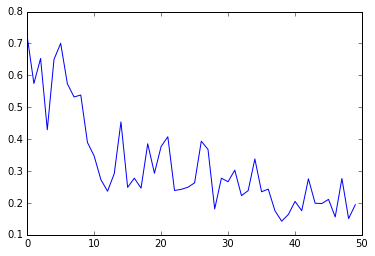

In [26]:
inds = np.argmax(np.abs(tica.feature_TIC_correlation),0)
corrs = np.max(np.abs(tica.feature_TIC_correlation),0)
plt.plot(corrs)

In [27]:
def compute_eigenvalue_of_trial_direction(trial_direction):
    A = np.reshape(trial_direction, (len(trial_direction), 1))
    C = tica.cov_tau
    S = tica.cov

    return np.trace((A.T.dot(C).dot(A)).dot(np.linalg.inv(A.T.dot(S).dot(A))))

In [28]:
compute_eigenvalue_of_trial_direction(np.ones(len(X[0].T)))

0.40212813524528368

In [29]:
n_features = X[0].shape[1]
eigs = np.zeros(n_features)

for i in range(n_features):
    trial_direction = np.zeros(n_features)
    trial_direction[i] = 1
    eigs[i] = compute_eigenvalue_of_trial_direction(trial_direction)

In [30]:
np.max(eigs)

0.88217899617186146

In [31]:
np.argmax(eigs)

1293

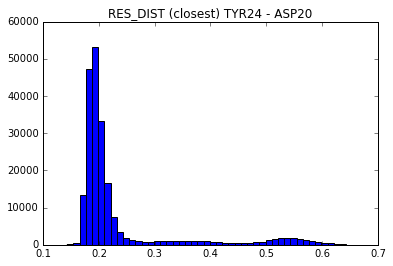

In [32]:
plt.hist(np.vstack(X)[:,np.argmax(eigs)],bins=50);
plt.title(feat.describe()[np.argmax(eigs)])

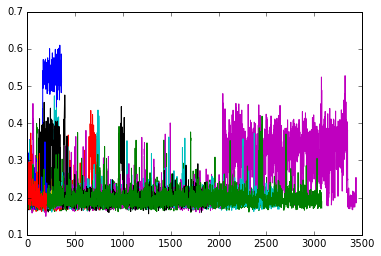

In [33]:
for x in X[::10]:
    plt.plot(x[:,np.argmax(eigs)])

In [34]:
tica.eigenvalues[0]

0.95454335952854341

In [35]:
(tica.timescales[0] * recording_interval).value_in_unit(microsecond)

0.21495109347518176

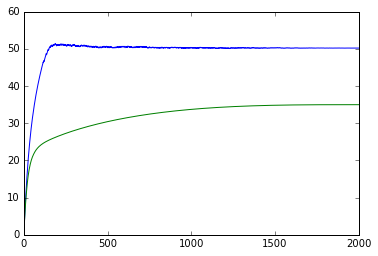

In [36]:
plt.plot(np.cumsum(tica.eigenvalues))
plt.plot()
plt.plot(np.cumsum(tica.eigenvalues**2))

In [37]:
X_tica = tica.get_output()
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica, k=500, max_iter=100)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]
msm = pyemma.msm.estimate_markov_model(dtrajs, lag_frames)

30-09-16 23:53:47 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[1] INFO     Algorithm did not reach convergence criterion of 1e-05 in 100 iterations. Consider increasing max_iter.


In [38]:
np.trace(msm.P)

196.5722983679448

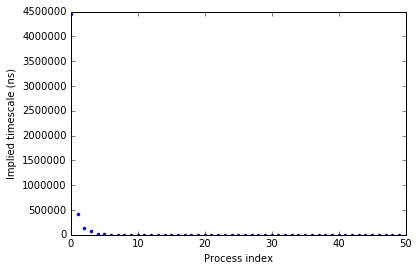

In [39]:
plt.plot((msm.timescales()[:50] * recording_interval).value_in_unit(nanosecond),'.')
#plt.yscale('log')
plt.ylabel('Implied timescale (ns)')
plt.xlabel('Process index')

In [40]:
from sklearn.cluster import SpectralClustering
clust = SpectralClustering(4,affinity='precomputed')
clust.fit(msm.P)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:629: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=4, n_init=10, n_neighbors=10,
          random_state=None)

In [41]:
labels = clust.labels_

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


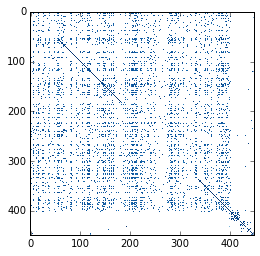

In [42]:
plt.imshow(np.log(msm.P)[np.argsort(labels)][:,np.argsort(labels)],interpolation='none',cmap='Blues')

In [43]:
timescale_of_interest = 100 * nanoseconds
tau = int(timescale_of_interest / lag_time)
tau

10

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


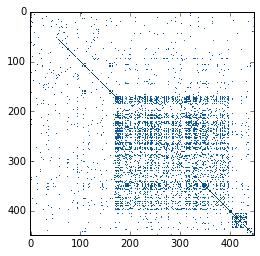

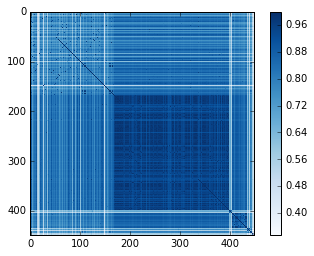

In [44]:
affinity_matrix, cg = diffusion_cluster(msm, tau = tau)

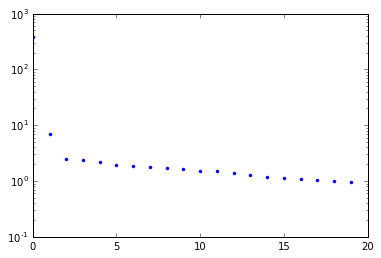

In [45]:
vals,vecs = np.linalg.eigh(affinity_matrix)
plt.plot(vals[::-1][:20],'.')
plt.yscale('log')

In [119]:
# what happens if I discretize directly in the space of "1-sparse approximate tICs"?
# I may not have _the slowest_ possible input order parameters, but at least we can see what they are...
    
def unique_ify_but_preserve_order(array):
    '''
    Given an array with possibly non-unique elements, remove the redundant elements, but preserve their order 
    (i.e. don't just do list(set(array)))
    
    Returns
    -------
    unique_array : array of now unique elements from array
    
    '''
    
    # if the elements are already all unique, return the array un-modified
    if len(set(array)) == len(array): return range(len(array)), array
    
    # keep track of the elements we've seen so far
    seen_so_far = set()
    new_list = []
    for i, element in enumerate(array):
        if element not in seen_so_far:
            new_list.append(element)
            seen_so_far.add(element)
    return np.array(new_list)

def feature_select(tica, max_components = 50):
    '''
    "x-axis (tIC1) is a weighted combination of these inter-residue distances" is difficult to interpret.
    Luckily, tIC1 often turns out to be 
    '''
    
    # get the list of feature indices that are maximally correlated with each independent component
    possibly_redundant_features = np.argmax(np.abs(tica.feature_TIC_correlation),0)[:max_components]
    features = unique_ify_but_preserve_order(possibly_redundant_features)[:max_components]
    
    ## also get their correlation values?
    #corrs = np.max(np.abs(tica.feature_TIC_correlation),0)[inds]
    
    return features
                
def compute_eigenvalue_of_trial_direction(tica, trial_direction):
    A = np.reshape(trial_direction, (len(trial_direction), 1))
    C = tica.cov_tau
    S = tica.cov

    return np.trace((A.T.dot(C).dot(A)).dot(np.linalg.inv(A.T.dot(S).dot(A))))

def get_eigenvalues(tica, features):
    '''
    We would also like to weight each axis by how "slow" it is, so that the 1-sparse approximation is
    still roughly a kinetic distance.
    '''
    eigs = np.array(len(features))
    for i, feat in enumerate(features):
        trial_direction = np.zeros(len(tica.mean))
        trial_direction[feat] = 1
        eigs[i] = compute_eigenvalue_of_trial_direction(tica, trial_direction)
    return eigs
    
def get_one_sparse_approximate_projection(X, tica, max_components = 50):
    features = feature_select(tica, max_components = max_components)
    eigenvalues = get_eigenvalues(tica, features)
    return [x[:,features] * eigenvalues for x in X]

In [116]:
(tica.mean).shape

(2775,)

In [55]:
inds = feature_select(tica)
X_ = [x[:, inds] for x in X]
features = [feat.describe()[i] for i in inds]

In [57]:
kmeans_ = pyemma.coordinates.cluster_mini_batch_kmeans(X_, k=500, max_iter=10)
dtrajs_ = [dtraj.flatten() for dtraj in kmeans_.get_output()]

01-10-16 00:00:52 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [58]:
msm_ = pyemma.msm.estimate_markov_model(dtrajs_, 10)
np.trace(msm_.P)

99.840118557563386

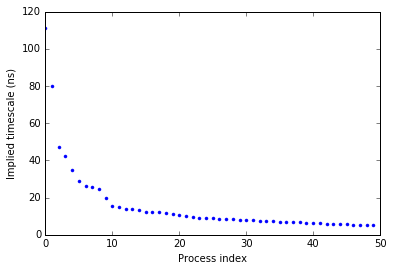

In [60]:
plt.plot((msm_.timescales()[:50] * recording_interval).value_in_unit(nanosecond),'.')
#plt.yscale('log')
plt.ylabel('Implied timescale (ns)')
plt.xlabel('Process index')

In [61]:
# what happens if we just greedily take the 50 slowest features, in this case? (they may be very redundant)

inds = np.argsort(eigs)[::-1][:50]
X_ = [x[:, inds] for x in X]
features = [feat.describe()[i] for i in inds]
kmeans_ = pyemma.coordinates.cluster_mini_batch_kmeans(X_, k=500, max_iter=10)
dtrajs_ = [dtraj.flatten() for dtraj in kmeans_.get_output()]
msm_ = pyemma.msm.estimate_markov_model(dtrajs_, 10)
np.trace(msm_.P)

01-10-16 00:04:07 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


44.750435053990515

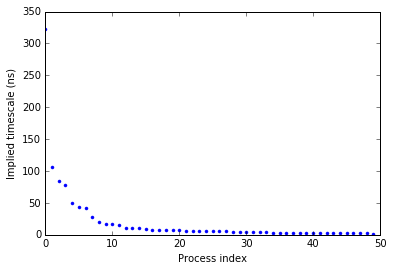

In [62]:
plt.plot((msm_.timescales()[:50] * recording_interval).value_in_unit(nanosecond),'.')
#plt.yscale('log')
plt.ylabel('Implied timescale (ns)')
plt.xlabel('Process index')

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


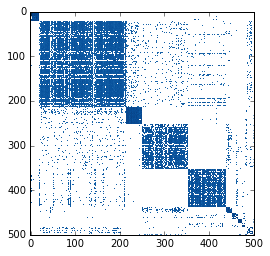

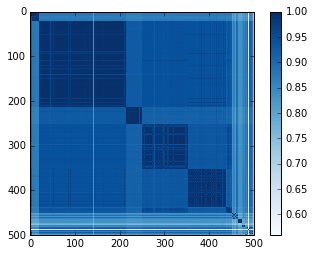

In [71]:
affinity_matrix, cg = diffusion_cluster(msm_, tau = 5, n_states=10)

In [73]:
msm_.active_count_fraction, msm_.active_state_fraction

(1.0, 1.0)

In [78]:
cg_dtrajs = [np.array([cg[i] for i in dtraj],dtype=int) for dtraj in dtrajs_]

In [79]:
from msmbuilder.msm import MarkovStateModel

In [80]:
msm = MarkovStateModel(10)

In [81]:
msm.fit(cg_dtrajs[::2])
msm.score_, msm.score(cg_dtrajs[1::2])

MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%


(7.8041207608194387, 7.7544504145280353)

In [82]:
msm.fit(cg_dtrajs)
msm.score_

MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%


9.2347056048412917

In [83]:
msm.fit(dtrajs_[::2])
msm.score_, msm.score(dtrajs_[1::2])

MSM contains 2 strongly connected components above weight=0.10. Component 1 selected, with population 99.990077%
MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%


(28.325950966809039, 27.637164115905762)